In [283]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn.covariance as cor

import sklearn.svm as svm
from sklearn.metrics import classification_report as clf_rpt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics  
from sklearn.model_selection import cross_val_score

# os.chdir('/Users/caojiawu/test')
data = pd.read_csv('train.csv')

#doAgeNull = 0, remove NaN; doAgeNull = 1, Set random value; doAgeNull = 2, Set predicted value;
doAgeNull = 2
doDummyVar = 1

# Multinomial Naive Bayes Classifier    
def naive_bayes_classifier(train_x, train_y):     
    from sklearn.naive_bayes import MultinomialNB    
    model = MultinomialNB(alpha=0.01)    
    model.fit(train_x, train_y)    
    return model    
   
    
# KNN Classifier    
def knn_classifier(train_x, train_y):    
    from sklearn.neighbors import KNeighborsClassifier    
    model = KNeighborsClassifier()    
    model.fit(train_x, train_y)    
    return model    
    
    
# Logistic Regression Classifier    
def logistic_regression_classifier(train_x, train_y):    
    from sklearn.linear_model import LogisticRegression    
    model = LogisticRegression(penalty='l2')    
    model.fit(train_x, train_y)    
    return model    
   
    
# Random Forest Classifier    
def random_forest_classifier(train_x, train_y):    
    from sklearn.ensemble import RandomForestClassifier    
    model = RandomForestClassifier(n_estimators=8)    
    model.fit(train_x, train_y)    
    return model    
    
    
# Decision Tree Classifier    
def decision_tree_classifier(train_x, train_y):    
    from sklearn import tree    
    model = tree.DecisionTreeClassifier()    
    model.fit(train_x, train_y)    
    return model    
    
    
# GBDT(Gradient Boosting Decision Tree) Classifier    
def gradient_boosting_classifier(train_x, train_y):    
    from sklearn.ensemble import GradientBoostingClassifier    
    model = GradientBoostingClassifier(n_estimators=200)    
    model.fit(train_x, train_y)    
    return model    
    
    
# SVM Classifier    
def svm_classifier(train_x, train_y):    
    from sklearn.svm import SVC    
    model = SVC(kernel='rbf', probability=True)    
    model.fit(train_x, train_y)    
    return model    
    
# SVM Classifier using cross validation    
def svm_cross_validation(train_x, train_y):    
    from sklearn.grid_search import GridSearchCV    
    from sklearn.svm import SVC    
    model = SVC(kernel='rbf', probability=True)    
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}    
    grid_search = GridSearchCV(model, param_grid, n_jobs = 1, verbose=1)    
    grid_search.fit(train_x, train_y)    
    best_parameters = grid_search.best_estimator_.get_params()    
    for para, val in list(best_parameters.items()):    
        print(para, val)    
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)    
    model.fit(train_x, train_y)    
    return model    
    


# 把每个年龄存活均值打印出来。需要注意的是部分年龄没有人和没有存活的人是不同的,但图中都显示的是0.

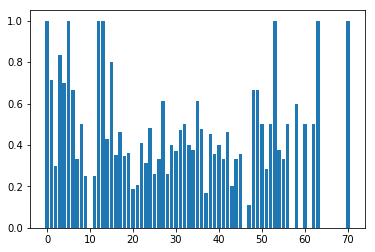

In [284]:
a = data[data['Age'].notnull()][['Survived','Age']]
a['Age'] = a['Age'].astype('int')
b=a.groupby('Age').mean()
plt.bar(range(len(b)),b['Survived'])
plt.show()

# 数据清洗，数据补全
对于可以利用的数据，如果数据是NaN，可以利用已有数据的统计特征进行最小误差引入的补全.

将性别转换为数值型：female=0，male=1.

Embarked取值没有连续性，因此将Embarked做哑变量处理，变成三个特征量：EmbarkedS,EmbarkedC,EmbarkedQ,取值为开关量[0,1]

Pclass同样做哑变量处理，变成三个特征量，Pclass1,Pclass2,Pclass3.



In [285]:
tempData = data

#let female=0 and male=1
tempData['Sex'] = tempData['Sex'].apply(lambda x: 0 if x=='female' else 1)

if doDummyVar == 1:
    tempData['Pclass1']=tempData['Pclass'].apply(lambda x: 1 if x==1 else 0)
    tempData['Pclass2']=tempData['Pclass'].apply(lambda x: 1 if x==2 else 0)
    tempData['Pclass3']=tempData['Pclass'].apply(lambda x: 1 if x==3 else 0)
    tempData = tempData.drop('Pclass',1)

    tempData['EmbarkedC']=tempData['Embarked'].apply(lambda x: 1 if x=='C' else 0)
    tempData['EmbarkedQ']=tempData['Embarked'].apply(lambda x: 1 if x=='Q' else 0)
    tempData['EmbarkedS']=tempData['Embarked'].apply(lambda x: 1 if x=='S' else 0)
    tempData = tempData.drop('Embarked',1)
else:
     tempData['Embarked'] = tempData['Embarked'].map({'C':0,'Q':1,'S':2})
#     tempData['Embarked'] = tempData['Embarked'].map({'C':2,'Q':1,'S':0})
#     tempData['Embarked'] = tempData['Embarked'].apply(lambda x: 0 if x=='C' else 1 if x=='Q' else 2)
tempData = tempData.drop('PassengerId',1)
tempData = tempData.drop('Name',1)
tempData = tempData.drop('Cabin',1)
tempData = tempData.drop('Ticket',1)



# NaN参数处理测试

几种对NaN参数处理的对比：
- 直接丢弃包含NaN参数的行

直接丢弃会造成样本数减少，损失了有用信息。
- 生成随机数填充NaN特征

下面的例子用高斯分布（Age均值，Age方差）去生成数据填充NaN列
- 利用其他有效特征去预测NaN列的值

此例中Age列是有价值的特征。利用其他列的值，选择可能和年龄相关的几列'Survived','SibSp','Fare','Pclass'预测Age列的值。此处用到的是回归算法。
注：网上有帖子提到，对于回归模型，根据情况需要做哑变量处理。

验证的时候需要注意，预测Age用的训练数据随机选择时，可能会由于选择的训练集合不同得到不同的结果，因此需要多做几个不同的random_state选择，然后与其他补NaN的测试结果对比。
做了几次测试后，预测Age值的手段会比随机补NaN的准确性要好。

In [286]:
if doAgeNull == 2:
    tempData_2 = tempData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
    
    if doDummyVar == 1:
        X_train, X_test,y_train,y_test = train_test_split(
#             tempData_2[['Sex','Survived','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']],
            tempData_2[['Survived','SibSp','Fare','Pclass1','Pclass2','Pclass3']],
            tempData_2['Age'],test_size=0.25,random_state=30)
    else:
        X_train, X_test,y_train,y_test = train_test_split(
            tempData_2[['Survived','SibSp','Fare','Pclass']],
            tempData_2['Age'],test_size=0.25,random_state=30)        

#     model = LinearRegression()
#     model = SVR(C=1024,gamma=0.5)
    model = Ridge(alpha=1.0)
    model.fit(X_train,y_train)

    u = model.score(X_test,y_test)
    print(u)

    m = tempData[tempData['Age'].isnull()]
    if doDummyVar == 1:
        v = model.predict(m[['Survived','SibSp','Fare','Pclass1','Pclass2','Pclass3']])
    else:
        v = model.predict(m[['Survived','SibSp','Fare','Pclass']])

    tempData['Age'][tempData['Age'].isnull()] = v
elif doAgeNull == 1:
    meanAge = tempData['Age'].mean()
    print(meanAge)
    m = tempData['Age'].mean()
    s = tempData['Age'].std()
    np.random.seed(0)
    tempData['Age'][tempData['Age'].isnull()] = tempData[tempData['Age'].isnull()]['Age'].apply(lambda x: np.random.normal(m,s,1))
    

    

0.253179319055


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 由于对样本做随机划分得到的训练级和测试集训练后的score表现为随机性，使用K折交叉验证


In [287]:
thresh = 0.5    

tempData = tempData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
tempData['Age']= tempData['Age'].apply(lambda x: (x-tempData.min()['Age'])/(tempData.max()['Age']-tempData.min()['Age']))
tempData['Fare'] = tempData['Fare'].apply(lambda x: (x-tempData.min()['Fare'])/(tempData.max()['Fare']-tempData.min()['Fare']))
tempData['SibSp'] = tempData['SibSp'].apply(lambda x: (x-tempData.min()['SibSp'])/(tempData.max()['SibSp']-tempData.min()['SibSp']))
tempData['Parch'] = tempData['Parch'].apply(lambda x: (x-tempData.min()['Parch'])/(tempData.max()['Parch']-tempData.min()['Parch']))

if doDummyVar == 1:
    train_x, test_x,train_y,test_y = train_test_split(
            tempData[['Sex','Age','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']],
            tempData['Survived'],test_size=0.33,random_state=42)
else:
    train_x, test_x,train_y,test_y = train_test_split(
            tempData[['Sex','Age','SibSp','Fare','Pclass','Embarked']],
            tempData['Survived'],test_size=0.33,random_state=42)      

# train_x =  train_x.astype('float64')
# test_x =  test_x.astype('float64')


     
test_classifiers = ['Multinomial_Naive_Bayes', 'KNN', 'LR', 'RF', 'DT', 'SVM', 'GBDT']    
classifiers = {'Multinomial_Naive_Bayes':naive_bayes_classifier,     
                  'KNN':knn_classifier,    
                   'LR':logistic_regression_classifier,    
                   'RF':random_forest_classifier,    
                   'DT':decision_tree_classifier,    
                  'SVM':svm_classifier,    
                 'GBDT':gradient_boosting_classifier    
}            

accu = []
for classifier in test_classifiers:    
    print('******************* %s ********************' % classifier)    
    model = classifiers[classifier](train_x, train_y)    
    predict = model.predict(test_x)    
    precision = metrics.precision_score(test_y, predict)    
    recall = metrics.recall_score(test_y, predict)    
    print('cross validation precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))    
    accuracy = metrics.accuracy_score(test_y, predict)    
    print('cross validation accuracy: %.2f%%' % (100 * accuracy))
    accu.append(accuracy)
    


    if doDummyVar == 1:
        scores = cross_val_score(model, 
                                 tempData[['Sex','Age','SibSp','Fare','Pclass1','Pclass2','Pclass3','EmbarkedC','EmbarkedQ','EmbarkedS']],
                                 tempData['Survived'],cv=6)
    else:
        scores = cross_val_score(model, tempData[['Sex','Age','SibSp','Fare','Pclass','Embarked']],tempData['Survived'],cv=6)
       
    print('mean of K-Folds scores:'+str(sum(scores)/len(scores)))
    print('K-Folds scores:'+str(scores))


******************* Multinomial_Naive_Bayes ********************
cross validation precision: 71.88%, recall: 57.50%
cross validation accuracy: 73.56%
mean of K-Folds scores:0.738617812443
K-Folds scores:[ 0.61744966  0.74496644  0.74496644  0.7027027   0.82432432  0.7972973 ]
******************* KNN ********************
cross validation precision: 83.17%, recall: 70.00%
cross validation accuracy: 82.03%
mean of K-Folds scores:0.820462240764
K-Folds scores:[ 0.75167785  0.82550336  0.85234899  0.86486486  0.81081081  0.81756757]
******************* LR ********************
cross validation precision: 80.95%, recall: 70.83%
cross validation accuracy: 81.36%
mean of K-Folds scores:0.803593022553
K-Folds scores:[ 0.76510067  0.81208054  0.83221477  0.78378378  0.7972973   0.83108108]
******************* RF ********************
cross validation precision: 77.31%, recall: 76.67%
cross validation accuracy: 81.36%
mean of K-Folds scores:0.82715097648
K-Folds scores:[ 0.79865772  0.84563758  0.8